# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][MS][ML][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [36]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [58]:
def read_data(path="/content/gdrive/My Drive/boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    scaler = MinMaxScaler()
    scaler.fit(dataframe)
    dataframe= scaler.transform(dataframe)

    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [59]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [60]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    MSE = np.square(y_true - y_predicted).mean()
    return MSE

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    SSres=np.square(y_true - y_predicted).mean()
    mean_true=y_true.mean()
    SStot=np.square(y_true - mean_true).mean()
    return 1 - (SSres)/(SStot)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [6]:
class NormalLR:
    def __init__(self):
        self.w = None

    def fit(self, X:np.ndarray, y:np.ndarray):

        const_col=np.ones(X.shape[0]).reshape(-1,1)
        X = np.concatenate((const_col, X), axis=1)
        self.w = np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,y))
        return
    
    def predict(self, X:np.ndarray) -> np.ndarray:

        const_col=np.ones(X.shape[0]).reshape(-1,1)
        X = np.concatenate((const_col, X), axis=1)
        pred = np.dot(X, self.w.T)
        return pred

In [7]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [8]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.010726795682017091, R2: 0.9982189994416782


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [9]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self.w = None
        self.alpha= alpha
        self.iterations=iterations
        self.l=l
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        
        const_col=np.ones(X.shape[0]).reshape(-1,1)
        X = np.concatenate((const_col, X), axis=1)
        self.w = np.zeros(X.shape[1])
        size=y.shape[0]

        for i in range(self.iterations):
            lasso = self.l * np.sign(self.w)
            err=np.dot(X , self.w) - y
            grad = (2 / size) * np.dot(X.T, err) + lasso
            self.w = self.w - self.alpha * grad

        

    def predict(self, X:np.ndarray) -> np.ndarray:

        const_col=np.ones(X.shape[0]).reshape(-1,1)
        X = np.concatenate((const_col, X), axis=1)
        pred = np.dot(X, self.w.T)
        return pred

In [10]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [14]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

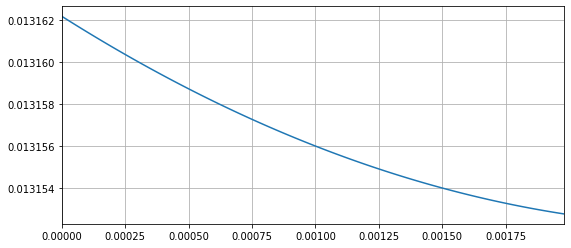

In [15]:
build_plot(X_train, y_train, X_val, y_val)

In [16]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009923194161777832, R2: 0.9975171011926397


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [61]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
X, y = read_data()

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

In [65]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
w=regr.w

print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 0.010995709175721938, R2: 0.6872797475661048


In [66]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)

print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 0.01099554179193606, R2: 0.6872845079957357


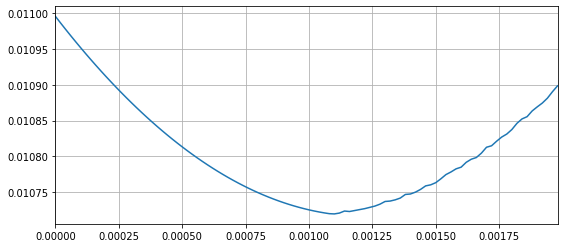

In [44]:
build_plot(X_train, y_train, X_val, y_val)

### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

In [67]:
with open("/content/gdrive/My Drive/boston.csv") as myfile:
    head = [next(myfile) for x in range(14)]
for i in range(13):
    print('{} : {}'.format(w[i+1],head[i]),end='')


-0.20512442609093584 : #  1. crim     per capita crime rate by town
0.11614932673079154 : #  2. zn       proportion of residential land zoned for lots over 25,000 sq.ft.
-0.012018117065459653 : #  3. indus    proportion of non-retail business acres per town
0.05162839253846152 : #  4. chas     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
-0.18632881744496188 : #  5. nox      nitric oxides concentration (parts per 10 million)
0.417982896138712 : #  6. rm       average number of rooms per dwelling
0.022744846682770437 : #  7. age      proportion of owner-occupied units built prior to 1940
-0.3752453669742176 : #  8. dis      weighted distances to five Boston employment centres
0.1674753562126392 : #  9. rad      index of accessibility to radial highways
-0.16856965131948934 : # 10. tax      full-value property-tax rate per $10,000
-0.1905947389492939 : # 11. ptratio  pupil-teacher ratio by town
0.07643774327227426 : # 12. b        1000(Bk - 0.63)^2 where Bk is th

Проанализируем коэффициенты при каждом признаке, и поймем как они влияют на стоимость квартиры (извиняюсь если неправильно перевела/поняла некоторые из фичей):  

1.   Уровень преступности влияет на стоимость квартиры отрицательно: в достаточной мере, чтобы это было заметно
2.   Если доля земли отданная под жилую застройку велика, то квартира стоит меньше. Такая отрицательная корреляция выражена не очень сильно
3.   Почти нет зависимости с уровнем не-розничной торговли
4.   Маленькая положительная зависимость с наличием реки неподалеку от квартиры
5.   Заметная отрицательная зависимость с концентрацией оксида азота - мало кто захочет дышать плохим воздухом
6.   Большая положительная зависимость стоимости жилья с количеством комнат в нем - кажется очень логичным
7.   Большой возраст квартир почти не влияет на стоимость (и все же корреляция положительна)
8.   Логично, что чем больше среднее расстояние до бостонских рабочих центров, тем меньше стоимость жилья
9.   Доступность магистралей увличивает стоимость квартиры
10.  Что то с налогами, видимо никто не хочет их платить поэтому стоимость жилья коррелирует с этим показателем отрицательно
11.  Примечательная отрицательная корреляция с количеством учеников на учителя: видимо квартиры продаются с расчетом на вдумчивых родителей
12.  Почти нет корреляции с долей чернокожего населения
13.  А вот с долей населения с низким статусом отрицательная корреляция очень заметна (наибольший по модулю коэффициент среди остальных!)


Почти все зависимости выглядят логично и поддаются объяснению. От некоторых признаков я ожидала другого влияния, но все из них в модели имеют маленькие (по модулю) коэффициенты и видимо в настоящую модель не привносят значимой информации.
